Sealevel monitor
========

This document is used to monitor the current sea level along the Dutch coast. The sea level is measured using a number of tide gauges. Six long running tide gauges are considered "main stations". The mean of these stations is used to estimate the "current sea-level rise". The measurements since 1890 are taken into account. Measurements before that are considered less valid because the Amsterdam Ordnance Datum was not yet normalized. 

In [1]:
# this is a list of packages that are used in this notebook
# these come with python
import io
import zipfile
import functools
import bisect
import datetime


# you can install these packages using pip or anaconda
# (requests numpy pandas bokeh pyproj statsmodels)

# for downloading
import requests
import netCDF4

# computation libraries
import numpy as np
import pandas as pd


# coordinate systems
import pyproj 

# statistics
import statsmodels.api as sm
import statsmodels.multivariate.pca
import statsmodels.tsa.seasonal


# plotting
import bokeh.io
import bokeh.plotting
import bokeh.tile_providers
import bokeh.palettes

import windrose
import matplotlib.colors
import matplotlib.cm
import matplotlib.pyplot as plt
matplotlib.projections.register_projection(windrose.WindroseAxes)
import cmocean.cm

# displaying things
from ipywidgets import Image
import IPython.display

In [2]:
# Some coordinate systems
WEBMERCATOR = pyproj.Proj(init='epsg:3857')
WGS84 = pyproj.Proj(init='epsg:4326')

# If this notebook is not showing up with figures, you can use the following url:
# https://nbviewer.ipython.org/github/openearth/notebooks/blob/master/sealevelmonitor.ipynb
bokeh.io.output_notebook()
# we're using matplotlib for polar plots (non-interactive)
%matplotlib inline
# does not work properly
# %matplotlib notebook


Loading BokehJS ...

Sea-level measurements
=============
In this section we download sea-level measurements. The global collection of tide gauge records at the PSMSL is used to access the data. The other way to access the data is to ask the service desk data at Rijkswaterstaat. There are two types of datasets the "Revised Local Reference" and "Metric". For the Netherlands the difference is that the "Revised Local Reference" undoes the corrections from the  NAP correction in 2014, to get a consistent dataset. Here we transform the RLR back to NAP (without undoing the correction).

In [3]:
psmsl_urls = {
    'met_monthly': 'http://www.psmsl.org/data/obtaining/met.monthly.data/met_monthly.zip',
    'rlr_monthly': 'http://www.psmsl.org/data/obtaining/rlr.monthly.data/rlr_monthly.zip',
    'rlr_annual': 'http://www.psmsl.org/data/obtaining/rlr.annual.data/rlr_annual.zip'
}
default_dataset_name = 'rlr_annual'

In [4]:
# the rlrnap computes the rlr back to  latest NAP (ignoring the undoing of the NAP correction)
# the alpha paramater is the dominant wind direction for the stations, based on de Ronde 2013
# id's are the station ids in the PSMSL dataset

main_stations = [
    {
        'id': 20,
        'name': 'Vlissingen', 
        'rlr2nap': lambda x: x - (6976-46),
        'alpha': 118
    },
    {
        'id': 22,
        'name': 'Hoek van Holland', 
        'rlr2nap': lambda x:x - (6994 - 121),
        'alpha': 117
    },
    {
        'id': 23,
        'name': 'Den Helder', 
        'rlr2nap': lambda x: x - (6988-42),
        'alpha': 107
    },
    {
        'id': 24,
        'name': 'Delfzijl', 
        'rlr2nap': lambda x: x - (6978-155),
        'alpha': 117
    },
    {
        'id': 25,
        'name': 'Harlingen', 
        'rlr2nap': lambda x: x - (7036-122),
        'alpha': 108
    },
    {
        'id': 32,
        'name': 'IJmuiden', 
        'rlr2nap': lambda x: x - (7033-83),
        'alpha': 110
    }
]
main_stations = pd.DataFrame(main_stations).set_index('id')
main_stations

,alpha,name,rlr2nap
id,,,
20,118,Vlissingen,<function <lambda> at 0x10fb06b70>
22,117,Hoek van Holland,<function <lambda> at 0x10fb06ae8>
23,107,Den Helder,<function <lambda> at 0x10fb36ea0>
24,117,Delfzijl,<function <lambda> at 0x10fb36d90>
25,108,Harlingen,<function <lambda> at 0x10fb47048>
32,110,IJmuiden,<function <lambda> at 0x10fb470d0>


In [5]:
# the main stations are defined by their ids
main_stations_idx = list(main_stations.index)
main_stations_idx

[20, 22, 23, 24, 25, 32]

In [6]:
# download the zipfile

zipfiles = {}


for dataset_name in psmsl_urls:
    resp = requests.get(psmsl_urls[dataset_name])

    # we can read the zipfile
    stream = io.BytesIO(resp.content)
    zf = zipfile.ZipFile(stream)
    zipfiles[dataset_name] = zf

# this list contains a table of 
# station ID, latitude, longitude, station name, coastline code, station code, and quality flag
csvtext = zipfiles[dataset_name].read('{}/filelist.txt'.format(dataset_name))

stations = pd.read_csv(
    io.BytesIO(csvtext), 
    sep=';',
    names=('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality'),
    converters={
        'name': str.strip,
        'quality': str.strip
    }
)
stations = stations.set_index('id')

# the dutch stations in the PSMSL database, make a copy
# or use stations.coastline_code == 150 for all dutch stations
selected_stations = pd.merge(main_stations, stations, left_index=True, right_index=True)
# set the main stations, this should be a list of 6 stations
selected_stations['name'] = selected_stations['name_x']
selected_stations

,alpha,name_x,rlr2nap,lat,lon,name_y,coastline_code,station_code,quality,name
id,,,,,,,,,,
20,118,Vlissingen,<function <lambda> at 0x10fb06b70>,51.442222,3.596111,VLISSINGEN,150,101,N,Vlissingen
22,117,Hoek van Holland,<function <lambda> at 0x10fb06ae8>,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N,Hoek van Holland
23,107,Den Helder,<function <lambda> at 0x10fb36ea0>,52.964444,4.745000,DEN HELDER,150,31,N,Den Helder
24,117,Delfzijl,<function <lambda> at 0x10fb36d90>,53.326389,6.933056,DELFZIJL,150,1,N,Delfzijl
25,108,Harlingen,<function <lambda> at 0x10fb47048>,53.175556,5.409444,HARLINGEN,150,21,N,Harlingen
32,110,IJmuiden,<function <lambda> at 0x10fb470d0>,52.462222,4.554722,IJMUIDEN,150,41,N,IJmuiden


In [7]:
# show all the stations on a map

# compute the bounds of the plot
sw = (50, -5)
ne = (55, 10)
# transform to web mercator
sw_wm = pyproj.transform(WGS84, WEBMERCATOR, sw[1], sw[0])
ne_wm = pyproj.transform(WGS84, WEBMERCATOR, ne[1], ne[0])
# create a plot
fig = bokeh.plotting.figure(tools='pan, wheel_zoom', plot_width=600, plot_height=200, x_range=(sw_wm[0], ne_wm[0]), y_range=(sw_wm[1], ne_wm[1]))
fig.axis.visible = False
# add some background tiles
fig.add_tile(bokeh.tile_providers.STAMEN_TERRAIN)
# add the stations
x, y = pyproj.transform(WGS84, WEBMERCATOR, np.array(stations.lon), np.array(stations.lat))
fig.circle(x, y)
x, y = pyproj.transform(WGS84, WEBMERCATOR, np.array(selected_stations.lon), np.array(selected_stations.lat))
_ = fig.circle(x, y, color='red')


In [8]:
# show the plot
bokeh.io.show(fig)

Now that we have defined which tide gauges we are monitoring we can start downloading the relevant data. 

In [9]:
# each station has a number of files that you can look at.
# here we define a template for each filename

# stations that we are using for our computation
# define the name formats for the relevant files
url_names = {
    'datum': '{dataset_name}/RLR_info/{id}.txt',
    'diagram': '{dataset_name}/RLR_info/{id}.png',
    'url': 'http://www.psmsl.org/data/obtaining/rlr.diagrams/{id}.php',
    'rlr_monthly': '{dataset_name}/data/{id}.rlrdata',
    'rlr_annual': '{dataset_name}/data/{id}.rlrdata',
    'met_monthly': '{dataset_name}/data/{id}.metdata',
    'doc': '{dataset_name}/docu/{id}.txt',
    'contact': '{dataset_name}/docu/{id}_auth.txt'
}

In [10]:
def get_url(station, dataset_name):
    """return the url of the station information (diagram and datum)"""
    info = dict(
        dataset_name=dataset_name,
        id=station.name
    )
    url = url_names['url'].format(**info)
    return url

for dataset_name in psmsl_urls:
    # fill in the dataset parameter using the global dataset_name
    f = functools.partial(get_url, dataset_name=dataset_name)
    # compute the url for each station
    selected_stations[dataset_name] = selected_stations.apply(f, axis=1)
selected_stations

,alpha,name_x,rlr2nap,lat,lon,name_y,coastline_code,station_code,quality,name,met_monthly,rlr_monthly,rlr_annual
id,,,,,,,,,,,,,
20,118,Vlissingen,<function <lambda> at 0x10fb06b70>,51.442222,3.596111,VLISSINGEN,150,101,N,Vlissingen,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
22,117,Hoek van Holland,<function <lambda> at 0x10fb06ae8>,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N,Hoek van Holland,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
23,107,Den Helder,<function <lambda> at 0x10fb36ea0>,52.964444,4.745000,DEN HELDER,150,31,N,Den Helder,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
24,117,Delfzijl,<function <lambda> at 0x10fb36d90>,53.326389,6.933056,DELFZIJL,150,1,N,Delfzijl,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
25,108,Harlingen,<function <lambda> at 0x10fb47048>,53.175556,5.409444,HARLINGEN,150,21,N,Harlingen,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
32,110,IJmuiden,<function <lambda> at 0x10fb470d0>,52.462222,4.554722,IJMUIDEN,150,41,N,IJmuiden,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...


Sea-level explained  
=======
The sea-level is dependent on several factors. We call these factors explanatory, exogenous or independent variables. The main factors that influence the monthly and annual sea level include wind, pressure, river discharge, tide and oscilations in the ocean. Based on previous analysis we include wind and nodal tide as independent variables. To be able to include wind, we use the monthly 10m wind based on the NCEP reanlysis of the NCAR. To be more specific we include the squared u and v wind components. Unfortunately the wind series only go back to 1948. To be able to include them without having to discard the sea level measurements before 1948, we fill in the missing data with the mean. 

We don't include timeseries of volume based explanatory variables like 

In [11]:
def make_wind_df(lat_i=53, lon_i=3):
    """create a dataset for wind, for 1 latitude/longitude"""
    u_file = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface_gauss/uwnd.10m.mon.mean.nc'
    v_file = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface_gauss/vwnd.10m.mon.mean.nc'

    # open the 2 files
    ds_u = netCDF4.Dataset(u_file)
    ds_v = netCDF4.Dataset(v_file)
    
    # read lat,lon, time from 1 dataset
    lat, lon, time = ds_u.variables['lat'][:], ds_u.variables['lon'][:], ds_u.variables['time'][:]
    
    # check with the others
    lat_v, lon_v, time_v = ds_v.variables['lat'][:], ds_v.variables['lon'][:], ds_v.variables['time'][:]
    assert (lat == lat_v).all() and (lon == lon_v).all() and (time == time_v).all()
    
    # convert to datetime
    t = netCDF4.num2date(time, ds_u.variables['time'].units)
    
    def find_closest(lat, lon, lat_i=lat_i, lon_i=lon_i):
        """lookup the index of the closest lat/lon"""
        Lon, Lat = np.meshgrid(lon, lat)
        idx = np.argmin(((Lat - lat_i)**2 + (Lon - lon_i)**2))
        Lat.ravel()[idx], Lon.ravel()[idx]
        [i, j] = np.unravel_index(idx, Lat.shape)
        return i, j
    
    # this is the index where we want our data
    i, j = find_closest(lat, lon)
    
    # get the u, v variables
    print('found point', lat[i], lon[j])
    u = ds_u.variables['uwnd'][:, i, j]
    v = ds_v.variables['vwnd'][:, i, j]

    # compute derived quantities
    speed = np.sqrt(u**2 + v**2)
    
    # compute direction in 0-2pi domain
    direction = np.mod(np.angle(u + v * 1j), 2*np.pi)
    
    # put everything in a dataframe
    wind_df = pd.DataFrame(data=dict(u=u, v=v, t=t, speed=speed, direction=direction))
    wind_df = wind_df.set_index('t')


    # return it
    return wind_df
wind_df = make_wind_df()

found point 52.3799 3.75


In [12]:
# label set to xxxx-01-01 of the current year
annual_wind_df = wind_df.resample('A', label='left', loffset=datetime.timedelta(days=1)).mean()
annual_wind_df['speed'] = np.sqrt(annual_wind_df['u']**2 + annual_wind_df['v']**2)
annual_wind_df['direction'] = np.mod(np.angle(annual_wind_df['u'] + annual_wind_df['v'] * 1j), 2*np.pi)

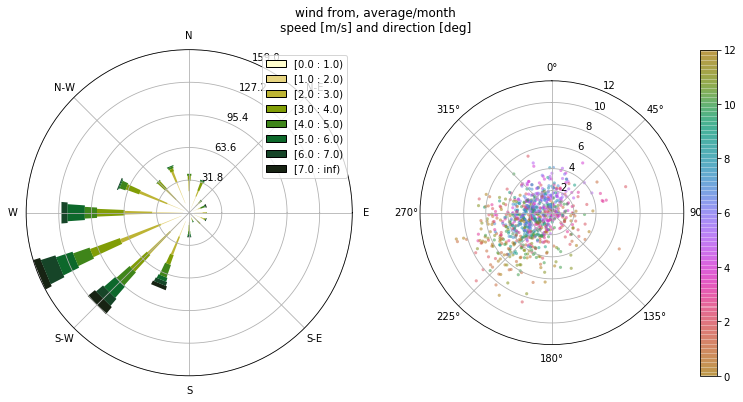

In [13]:
# create a wide figure, showing 2 wind roses with some extra info
fig = plt.figure(figsize=(13, 6))
# we're creating 2 windroses, one boxplot
ax = fig.add_subplot(1, 2, 1, projection='windrose')
ax = windrose.WindroseAxes.from_ax(ax=ax)
# from radians 0 east, ccw to 0 north cw, use meteo convention of "wind from" (270 - math degrees)
# see for example: http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv.html
wind_direction_meteo = np.mod(270 - (360.0 * wind_df.direction / (2*np.pi)), 360)
# create a box plot
ax.box(wind_direction_meteo, wind_df.speed, bins=np.arange(0, 8, 1), cmap=cmocean.cm.speed)
ax.legend(loc='best')

# and a scatter showing the seasonal pattern (colored by month)
ax = fig.add_subplot(1, 2, 2, 
    projection='polar',
    theta_direction=-1,
    theta_offset=np.pi/2.0
)
N = matplotlib.colors.Normalize(1, 12)
months = [x.month for x in wind_df.index]
sc = ax.scatter(
    # here we need radians, but again use math -> meteo conversion
    (np.pi + np.pi/2)-wind_df.direction, 
    wind_df.speed, 
    c=months, 
    cmap=cmocean.cm.phase, 
    vmin=0, 
    vmax=12,
    alpha=0.5,
    s=10,
    edgecolor='none'
)
_ = plt.colorbar(sc, ax=ax)
_ = fig.suptitle('wind from, average/month\nspeed [m/s] and direction [deg]')

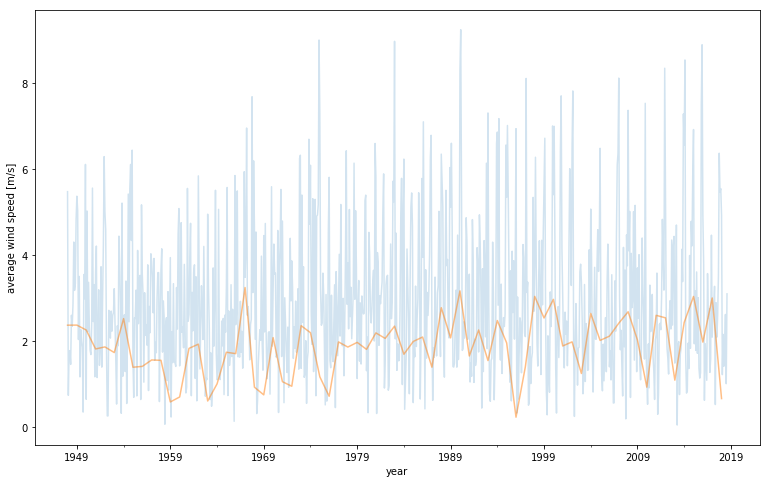

In [14]:
fig, ax = plt.subplots(figsize=(13, 8))
wind_df['speed'].plot(alpha=0.2, ax=ax)
annual_wind_df['speed'].plot(alpha=0.5, ax=ax)
ax.set_xlabel('year')
ax.set_ylabel('average wind speed [m/s]');

In [15]:
def missing2nan(value, missing=-99999):
    """convert the value to nan if the float of value equals the missing value"""
    value = float(value)
    if value == missing:
        return np.nan
    return value

def year2date(year_fraction, dtype='datetime64[s]'):
    """convert a fraction of a year + fraction of a year to a date, for example 1993.12 -> 1993-02-01.
    The dtype should be a valid numpy datetime unit, such as datetime64[s]"""
    startpoints = np.linspace(0, 1, num=12, endpoint=False)
    remainder = np.mod(year_fraction, 1)
    year = np.floor_divide(year_fraction, 1).astype('int')
    month = np.searchsorted(startpoints, remainder)
    if (month == 0).all():
        # if month is set to 0 (for annual data), set to january
        month = np.ones_like(month)
    dates = [
        datetime.datetime(year_i, month_i, 1) 
        for year_i, month_i 
        in zip(year, month)
    ]
    datetime64s = np.asarray(dates, dtype=dtype)
    return datetime64s

In [16]:
def compute_u2v2(df):
    """compute the u2 and v2 based on the direction and alpha"""

    # convert alpha to radians and from North 0, CW to 0 east, CW
    # x * pi / 180 
    alpha_in_rad = np.deg2rad(90 - df['alpha'])
    direction_in_rad = np.arctan2(df['v'], df['u'])
    df['u2main'] = (wind_df['speed'] ** 2) * np.cos(direction_in_rad - alpha_in_rad)
    df['u2perp'] = (wind_df['speed'] ** 2) * np.sin(direction_in_rad - alpha_in_rad)

    # the squared wind speed components along and perpendicular to the coastline
    df['u2main'].fillna(df['u2main'].mean(), inplace=True)
    df['u2perp'].fillna(df['u2perp'].mean(), inplace=True)
    df['u2'] = df['u']**2 * np.sign(df['u'])
    df['v2'] = df['v']**2 * np.sign(df['v'])
    df['u2'].fillna(df['u2'].mean(), inplace=True)
    df['v2'].fillna(df['v2'].mean(), inplace=True)

    return df

In [17]:
def get_data(station, dataset_name):
    """get data for the station (pandas record) from the dataset (url)"""
    info = dict(
        dataset_name=dataset_name,
        id=station.name
    )
    bytes = zipfiles[dataset_name].read(url_names[dataset_name].format(**info))
    df = pd.read_csv(
        io.BytesIO(bytes), 
        sep=';', 
        names=('year', 'height', 'interpolated', 'flags'),
        converters={
            "height": lambda x: station['rlr2nap'](missing2nan(x)),
            "interpolated": str.strip,
        }
    )
    df['station'] = station.name
    df['t'] = year2date(df.year, dtype=wind_df.index.dtype)
    df['alpha'] = station['alpha']
    df = df.set_index('t')
    # merge the wind and water levels
    if 'monthly' in dataset_name:
        merged = pd.merge(df, wind_df, how='left', left_index=True, right_index=True)
    else:
        merged = pd.merge(df, annual_wind_df, how='left', left_index=True, right_index=True)
    merged = compute_u2v2(merged)
    
        
    return merged

In [18]:
# get data for all stations
for dataset_name in psmsl_urls:
    f = functools.partial(get_data, dataset_name=dataset_name)
    # look up the data for each station
    selected_stations[dataset_name] = [f(station) for _, station in selected_stations.iterrows()]

Now that we have all data downloaded we can compute the mean.

In [19]:
# compute the mean

grouped = pd.concat(selected_stations[dataset_name].tolist())[['year', 'height', 'u2main', 'u2perp', 'u2', 'v2']].groupby(['year'])
mean_df = grouped.mean().reset_index()
# filter out non-trusted part (before NAP)
mean_df = mean_df[mean_df['year'] >= 1890].copy()

In [20]:
def timeseries_plot(dataset_name=default_dataset_name):
    # show all the stations, including the mean
    title = 'Sea-surface height for Dutch tide gauges [{year_min} - {year_max}]'.format(
        year_min=mean_df.year.min(),
        year_max=mean_df.year.max() 
    )
    fig = bokeh.plotting.figure(title=title, x_range=(1860, 2020), plot_width=900, plot_height=400)
    colors = bokeh.palettes.Accent7
    # no yellow
    del colors[3]
    for color, (id_, station) in zip(colors, selected_stations.iterrows()):
        data = station[dataset_name]
        fig.circle(data.year, data.height, color=color, legend=station['name'], alpha=0.5, line_width=1)
    fig.line(mean_df.year, mean_df.height, line_width=1, alpha=0.7, color='black', legend='Mean')
    fig.legend.location = "bottom_right"
    fig.yaxis.axis_label = 'waterlevel [mm] above NAP'
    fig.xaxis.axis_label = 'year'
    fig.legend.click_policy = "hide"
    return fig


In [21]:
bokeh.io.show(timeseries_plot(default_dataset_name))

In [22]:
bokeh.io.show(timeseries_plot('rlr_monthly'))

Methods
=====
Now we can define the statistical model. The "current sea-level rise" is defined by the following formula. Please note that t is relative to the epoch of 1970. This model is referred to as `linear_model` in the code. 
$
H(t) = a + b_{trend}(t) + b_u\cos(2\pi\frac{t}{18.613}) + b_v\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t) 
$

The terms are refered to as Constant ($a$), Trend ($b_{trend}$), Nodal U ($b_u$) and Nodal V ($b_v$), Wind ($b_{wind^2}$), the autoregressive term $\varepsilon(t-1)$ and error $\varepsilon$. 


Alternative models are used to detect if sea-level rise is increasing. These models include the broken linear model, defined by a possible change in trend starting at 1993. This timespan is the start of the "satellite era" (start of TOPEX/Poseidon measurements), it is also often referred to as the start of acceleration because the satellite measurements tend to show a higher rate of sea level than the "tide-gauge era" (1900-2000). If this model fits better than the linear model, one could say that there is a "increase in sea-level rise".  This model is refered to as `broken_linear_model`. These models are covered in the section [Sea-level acceleration](#Is-there-a-sea-level-acceleration?).

$
H(t) = a + b_{trend}(t) + b_{broken}(t > 1993)*(t-1993) + b_{u}\cos(2\pi\frac{t}{18.613}) + b_{v}\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t) 
$

Another way to look at increased sea-level rise is to look at sea-level acceleration. To detect sea-level acceleration one can use a quadratic model. This model is referred to as `quadratic_model`. 

$
H(t) = a + b_{trend}(t) + b_{quadratic}(t*t) + b_{u}\cos(2\pi\frac{t}{18.613}) + b_{v}\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t) 
$



In [23]:
# define the statistical model
def linear_model(df, with_wind=True, with_ar=True):
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend', 'Nodal U', 'Nodal V']
    if with_wind:
        X = np.c_[
            X, 
            df['u2'],
            df['v2']
        ]
        names.extend(['Wind $u^2$', 'Wind $v^2$'])
    X = sm.add_constant(X)
    if with_ar:
        model = sm.GLSAR(y, X, missing='drop', rho=1)
    else:
        model = sm.OLS(y, X, missing='drop')
    fit = model.fit(cov_type='HC0')
    return fit, names

We can compare the model with and without wind. Wind drives the storm surge at the coast. If there is a strong wind blowing it can raise the waterlevel by meters, 2 meter is not uncommon. If the wind keeps blowing for two days this will raise the annual averaged waterlevel by more than a centimeter, even if it occurs during low tide. 
We can verify that wind is an important factor for the average sea level by comparing the model with and without wind. 
Things to check for include: 
- Durbin Watson should be >1 for no worries, >2 for no autocorrelation
- JB should be non-significant for normal residuals
- abs(x2.t) + abs(x3.t) should be > 3, otherwise adding nodal is not useful
- The model with wind should also be significant better, check F value difference with 2 and N-5 degrees of freedom. 

In [24]:
# first the model without wind and AR
linear_fit, names = linear_model(mean_df, with_wind=False, with_ar=False)
table = linear_fit.summary(yname='Sea-surface height', xname=names, title='Linear model without (1890-current)')
IPython.display.display(table)

# and then the model with wind
linear_with_wind_fit, names = linear_model(mean_df, with_wind=True)
table = linear_with_wind_fit.summary(
    yname='Sea-surface height', 
    xname=names,
    title='Linear model with wind (1948-current)'
)
IPython.display.display(table)

if (linear_fit.aic < linear_with_wind_fit.aic):
    print('The linear model without wind is a higher quality model (smaller AIC) than the linear model with wind.')
else:
    print('The linear model with wind is a higher quality model (smaller AIC) than the linear model without wind.')



<class 'statsmodels.iolib.summary.Summary'>
"""
                     Linear model without (1890-current)                      
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     283.9
Date:                Wed, 19 Sep 2018   Prob (F-statistic):           2.36e-55
Time:                        00:35:13   Log-Likelihood:                -611.65
No. Observations:                 128   AIC:                             1231.
Df Residuals:                     124   BIC:                             1243.
Df Model:                           3                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.9978      2.912     -8.241      0.000     -29.705     -18.291
Trend          1.9252      0.066     29.071      0.000       1.795       2.055
Nodal U        5.1676      3.703      1.396      0.163      -2.090      12.425
Nodal V      -12.3294      3.494     -3.528      0.000     -19.178      -5.481
==============================================================================
Omnibus:                        3.475   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.176   Jarque-Bera (JB):                3.152
Skew:                          -0.383   Prob(JB):                        0.207
Kurtosis:                       3.072   Cond. No.                         57.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with wind (1948-current)                     
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.907
Model:                          GLSAR   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     357.1
Date:                Wed, 19 Sep 2018   Prob (F-statistic):           1.19e-70
Time:                        00:35:13   Log-Likelihood:                -578.76
No. Observations:                 127   AIC:                             1170.
Df Residuals:                     121   BIC:                             1187.
Df Model:                           5                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -62.4484      4.775    -13.078      0.000     -71.807     -53.090
Trend          1.8565      0.056     32.919      0.000       1.746       1.967
Nodal U        3.4661      2.863      1.211      0.226      -2.145       9.077
Nodal V      -10.5036      2.968     -3.539      0.000     -16.321      -4.687
Wind $u^2$    10.8999      1.082     10.072      0.000       8.779      13.021
Wind $v^2$     1.5841      2.656      0.596      0.551      -3.621       6.790
==============================================================================
Omnibus:                        2.617   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.270   Jarque-Bera (JB):                2.185
Skew:                          -0.186   Prob(JB):                        0.335
Kurtosis:                       3.524   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

The linear model with wind is a higher quality model (smaller AIC) than the linear model without wind.


In [25]:
# plot the model with wind. 
fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
fig.circle(mean_df.year, mean_df.height, line_width=1, legend='Monthly mean sea level', color='black', alpha=0.5)
fig.line(
    linear_with_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_wind_fit.predict(), 
    line_width=3, 
    alpha=0.5,
    legend='Current sea level, corrected for wind influence'
)
fig.line(
    linear_fit.model.exog[:, 1] + 1970, 
    linear_fit.predict(), 
    line_width=3, 
    legend='Current sea level', 
    color='green',
    alpha=0.5
)
fig.legend.location = "top_left"
fig.yaxis.axis_label = 'waterlevel [mm] above N.A.P.'
fig.xaxis.axis_label = 'year'
fig.legend.click_policy = "hide"

bokeh.io.show(fig)

Regional variability
=====================
It is known that the sea-level rise is not constant along the coast. The figures below show that the sea-level is rising faster at some stations. Some of these variations go back to the 1900's. There are several coastal interventions with known effect to the stations. The construction of the [Afsluitdijk](https://en.wikipedia.org/wiki/Afsluitdijk) (1927-1932), the [Oosterscheldekering](https://en.wikipedia.org/wiki/Oosterscheldekering) (1969-1987), the [Maeslantkering](https://en.wikipedia.org/wiki/Maeslantkering) (1991-1997) all have influence on the mean sea level, mainly due to changes in tidal amplitudes. 

Using the mean of the six tidal guages is the current approach. There are alternatives, for example one can use the principal component of the differences (between months/years). It is then assumed that only the common variance shared accross all stations is representative of the shared sea level. Most of the variance is shared between all stations and this results in a similar trend as using the mean. This method is referred to as EOF, PCA or SSA. See the analysis folder for an example.

In [26]:
p = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
colors = bokeh.palettes.Accent6

for color, (name, station) in zip(colors, selected_stations.iterrows()):
    df = station[default_dataset_name]
    df = df[df.year >= 1890]
    fit, names = linear_model(df, with_wind=True)
    smry = fit.summary(xname=names, title=station['name'])
    # somehow a formatted name is not showing up
    print(station['name'])

    IPython.display.display(smry.tables[1])
    p.circle(station[default_dataset_name].year, station[default_dataset_name].height, alpha=0.1, color=color)
# loop again so we have the lines on top
for color, (name, station) in zip(colors, selected_stations.iterrows()):
    df = station[default_dataset_name][station[default_dataset_name].year >= 1890]
    # ignore wind in the plots 
    fit, names = linear_model(df, with_wind=False)
    p.line(
        fit.model.exog[:, 1] + 1970, 
        fit.predict(), 
        line_width=3, 
        alpha=0.8,
        legend=station['name'],
        color=color
    )
p.legend.click_policy = "hide"

bokeh.io.show(p)


Vlissingen


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-97.4011,5.702,-17.082,0.000,-108.577,-86.225
Trend,2.1406,0.071,30.034,0.000,2.001,2.280
Nodal U,3.9188,3.130,1.252,0.211,-2.216,10.054
Nodal V,-12.6817,3.629,-3.495,0.000,-19.794,-5.570
Wind $u^2$,6.2500,1.337,4.676,0.000,3.630,8.870
Wind $v^2$,-1.3048,3.233,-0.404,0.687,-7.642,5.032


Hoek van Holland


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-45.4646,6.637,-6.850,0.000,-58.473,-32.456
Trend,2.3102,0.061,37.690,0.000,2.190,2.430
Nodal U,-0.8662,3.299,-0.263,0.793,-7.331,5.599
Nodal V,-7.9326,3.292,-2.410,0.016,-14.385,-1.481
Wind $u^2$,10.6179,1.574,6.746,0.000,7.533,13.703
Wind $v^2$,2.1197,2.871,0.738,0.460,-3.507,7.747


Den Helder


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-101.0086,4.851,-20.822,0.000,-110.517,-91.501
Trend,1.4468,0.060,23.929,0.000,1.328,1.565
Nodal U,4.2032,2.879,1.460,0.144,-1.440,9.846
Nodal V,-11.3124,3.774,-2.998,0.003,-18.709,-3.916
Wind $u^2$,11.8963,1.093,10.885,0.000,9.754,14.038
Wind $v^2$,1.6742,2.906,0.576,0.565,-4.021,7.370


Delfzijl


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-18.7634,5.632,-3.332,0.001,-29.802,-7.725
Trend,1.9068,0.078,24.391,0.000,1.754,2.060
Nodal U,2.9970,4.238,0.707,0.479,-5.309,11.303
Nodal V,-10.1673,3.701,-2.747,0.006,-17.421,-2.914
Wind $u^2$,13.7408,1.399,9.820,0.000,10.998,16.483
Wind $v^2$,0.6869,3.506,0.196,0.845,-6.184,7.558


Harlingen


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-37.9753,6.307,-6.021,0.000,-50.338,-25.613
Trend,1.2544,0.069,18.262,0.000,1.120,1.389
Nodal U,1.0378,3.603,0.288,0.773,-6.023,8.099
Nodal V,-7.4100,3.506,-2.114,0.035,-14.281,-0.539
Wind $u^2$,14.3819,1.436,10.017,0.000,11.568,17.196
Wind $v^2$,4.1756,3.271,1.277,0.202,-2.235,10.586


IJmuiden


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-74.0776,5.884,-12.590,0.000,-85.610,-62.545
Trend,2.0803,0.076,27.336,0.000,1.931,2.229
Nodal U,9.5058,3.971,2.394,0.017,1.723,17.289
Nodal V,-13.5176,3.792,-3.564,0.000,-20.951,-6.085
Wind $u^2$,8.5126,1.286,6.618,0.000,5.991,11.034
Wind $v^2$,2.1533,3.208,0.671,0.502,-4.133,8.440


Is there a sea-level acceleration?
==================

The following section computes two common models to detect sea-level acceleration.  The broken linear model expects that sea level has been rising faster since 1990. The quadratic model assumes that the sea-level is accelerating continuously. Both models are compared to the linear model. The extra terms are tested for significance and the AIC is computed to see which model is "better". 

In [27]:

# define the statistical model
def broken_linear_model(df, with_wind=True):
    """This model fits the sea-level rise has started to rise faster in 1993."""
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        (df['year'] > 1993) * (df['year'] - 1993),
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    names = ['Constant', 'Trend', '+trend (1993)', 'Nodal U', 'Nodal V']
    if with_wind:
        X = np.c_[
            X, 
            df['u2'],
            df['v2']
        ]
        names.extend(['Wind $u^2$', 'Wind $v^2$'])
    X = sm.add_constant(X)
    model_broken_linear = sm.GLSAR(y, X, rho=1)
    fit = model_broken_linear.iterative_fit(cov_type='HC0')
    return fit, names
broken_linear_fit, broken_names = broken_linear_model(mean_df)

In [28]:
# define the statistical model
def quadratic_model(df, with_wind=True):
    """This model computes a parabolic linear fit. This corresponds to the hypothesis that sea-level is accelerating."""
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        (df['year'] - 1970) * (df['year'] - 1970),
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    names = ['Constant', 'Trend', 'Acceleration', 'Nodal U', 'Nodal V']
    if with_wind:
        X = np.c_[
            X, 
            df['u2'],
            df['v2']
        ]
        names.extend(['Wind $u^2$', 'Wind $v^2$'])
    X = sm.add_constant(X)
    model_quadratic = sm.GLSAR(y, X, rho=1)
    fit = model_quadratic.iterative_fit(cov_type='HC0')
    return fit, names
quadratic_fit, quadratic_names = quadratic_model(mean_df)

In [29]:
# summary of the broken linear model
print('rho=%s' % broken_linear_fit.history['rho'][-1])
IPython.display.display(broken_linear_fit.summary(yname='Sea-surface height', xname=broken_names))


rho=[0.18289108]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.876
Model:                          GLSAR   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     218.0
Date:                Wed, 19 Sep 2018   Prob (F-statistic):           4.64e-62
Time:                        00:35:13   Log-Likelihood:                -575.81
No. Observations:                 127   AIC:                             1166.
Df Residuals:                     120   BIC:                             1186.
Df Model:                           6                                         
Covariance Type:                  HC0                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant        -63.1466      5.373    -11.753      0.000     -73.677     -52.616
Trend             1.7974      0.085     21.041      0.000       1.630       1.965
+trend (1993)     0.6349      0.382      1.663      0.096      -0.113       1.383
Nodal U           3.5743      3.386      1.056      0.291      -3.062      10.211
Nodal V         -11.0603      3.463     -3.194      0.001     -17.848      -4.273
Wind $u^2$       10.7656      1.063     10.130      0.000       8.683      12.849
Wind $v^2$       -0.2717      2.526     -0.108      0.914      -5.223       4.680
==============================================================================
Omnibus:                        2.455   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                2.138
Skew:                          -0.123   Prob(JB):                        0.343
Kurtosis:                       3.586   Cond. No.                         89.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [30]:
# summary of the quadratic model
print('rho=%s' % quadratic_fit.history['rho'][-1])

quadratic_fit.summary(yname='Sea-surface height', xname=quadratic_names)

rho=[0.19105241]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.873
Model:                          GLSAR   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     212.1
Date:                Wed, 19 Sep 2018   Prob (F-statistic):           2.11e-61
Time:                        00:35:14   Log-Likelihood:                -576.42
No. Observations:                 127   AIC:                             1167.
Df Residuals:                     120   BIC:                             1187.
Df Model:                           6                                         
Covariance Type:                  HC0                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Constant       -61.6114      5.468    -11.267      0.000     -72.329     -50.894
Trend            1.8514      0.086     21.506      0.000       1.683       2.020
Acceleration    -0.0001      0.002     -0.074      0.941      -0.004       0.004
Nodal U          3.4605      3.451      1.003      0.316      -3.304      10.225
Nodal V        -10.6551      3.452     -3.086      0.002     -17.422      -3.889
Wind $u^2$      10.8391      1.112      9.748      0.000       8.660      13.018
Wind $v^2$       0.9587      2.681      0.358      0.721      -4.297       6.214
==============================================================================
Omnibus:                        2.514   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.284   Jarque-Bera (JB):                2.210
Skew:                          -0.126   Prob(JB):                        0.331
Kurtosis:                       3.595   Cond. No.                     5.15e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 5.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
def model_compare_plot():
    fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
    fig.circle(mean_df.year, mean_df.height, line_width=3, legend='Mean', color='black', alpha=0.5)
    fig.line(mean_df.year, linear_with_wind_fit.predict(), line_width=3, legend='Linear', color='#bbbb33')
    fig.line(mean_df.year, broken_linear_fit.predict(), line_width=3, color='#33bb33', legend='Broken')
    fig.line(mean_df.year, quadratic_fit.predict(), line_width=3, color='#3333bb', legend='Quadratic')

    fig.legend.location = "top_left"
    fig.yaxis.axis_label = 'waterlevel [mm] above N.A.P.'
    fig.xaxis.axis_label = 'year'
    fig.legend.click_policy = "hide"
    return fig
bokeh.io.show(model_compare_plot())

Conclusions
======
Below are some statements that depend on the output calculated above. 

In [32]:
msg = '''The current average waterlevel above NAP (in mm), 
based on the 6 main tide gauges for the year {year} is {height:.1f} cm.
The current sea-level rise is {rate:.0f} cm/century'''
print(msg.format(year=mean_df['year'].iloc[-1], height=linear_fit.predict()[-1]/10.0, rate=linear_fit.params.x1*100.0/10))

The current average waterlevel above NAP (in mm), 
based on the 6 main tide gauges for the year 2017 is 6.3 cm.
The current sea-level rise is 19 cm/century


In [33]:
if (linear_fit.aic < quadratic_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the quadratic model.')
else:
    print('The quadratic model is a higher quality model (smaller AIC) than the linear model.')
if (quadratic_fit.pvalues['x2'] < 0.05):
    print('The quadratic term is bigger than we would have expected under the assumption that there was no quadraticness.')
else:
    print('Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.')

The quadratic model is a higher quality model (smaller AIC) than the linear model.
Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.


In [34]:
if (linear_fit.aic < broken_linear_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the broken linear model.')
else:
    print('The broken linear model is a higher quality model (smaller AIC) than the linear model.')
if (broken_linear_fit.pvalues['x2'] < 0.05):
    print('The trend break is bigger than we would have expected under the assumption that there was no trend break.')
else:
    print('Under the assumption that there is no trend break, we would have expected a trend break as big as we have seen.')

The broken linear model is a higher quality model (smaller AIC) than the linear model.
Under the assumption that there is no trend break, we would have expected a trend break as big as we have seen.
